# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make conclusions) then **text answer** is **mandatory** and **is** part of the task
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model is parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Put your markdown formulas here below:

$$ L(w, w_0) = \dfrac{1}{N} \sum_{i=1}^N \ln(1+e^{-y_i \sum\limits_{j=1}^k \big( w_j x_i^j \big) - y_i w_0}) + \gamma \cdot \sum_{i=1}^k | w_i | + \beta \cdot \sum_{i=1}^k {w_i}^2 $$
$$ \dfrac{\partial L}{\partial w_i} \, = \, \dfrac{1}{N} \sum_{i=1}^N \bigg( \dfrac{1}{1 + e^{-y_i(w^T x_i + w_0)}} \cdot e^{-y_i(w^T x_i + w_0)} \cdot \big( - y_i x_i^i \big) \bigg) + \gamma \cdot \dfrac{w_i}{| w_i |} + 2 \cdot \beta \cdot w_i $$
$$ \nabla_w L(w, w_0) \, = \, \Big( \dfrac{\partial L}{\partial w_1}, \dots , \dfrac{\partial L}{\partial w_k} \Big) \, = \, \dfrac{1}{N} \sum_{i=1}^N \dfrac{-y_i \cdot e^{-y_i(w^T x_i + w_0)}}{1 + e^{-y_i(w^T x_i + w_0)}} \cdot x_i + \gamma \cdot { \Big( \dfrac{w_1}{| w_1 |}, \dots , \dfrac{w_k}{| w_k |} \Big) }^T + 2 \cdot \beta \cdot w $$
$$ \nabla_{w_0} L(w, w_0) \, = \, \Big( \dfrac{\partial L}{\partial w_0} \Big) \, = \, \left( \dfrac{1}{N} \sum_{i=1}^N \dfrac{-y_i \cdot e^{-y_i(w^T x_i + w_0)}}{1 + e^{-y_i(w^T x_i + w_0)}} \right) $$

**Reminder!**
Do not use loops in task 2 and task 3. Loss and grad functions should be implemented in matrix form, without loops.

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    
    """
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    """
    return 1 / y.shape[0] * np.sum(np.log(1 + np.exp(-y * (np.dot(X, w) + w0)))) + \
        gamma * np.sum(np.abs(w)) + beta * np.sum(w ** 2)

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization
    
    '''
    return 1 / y.shape[0] * np.dot((1 / (1 + np.exp(-y * (np.dot(X, w) + w0))) - 1) * y, X) \
        + gamma * np.sign(w) + 2 * beta * w, \
        1 / y.shape[0] * np.sum((1 / (1 + np.exp(-y * (np.dot(X, w) + w0))) - 1) * y)

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [71]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42, threshold=0.5):  
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge
        
        '''
        self.beta = beta        
        self.gamma = gamma
        self.lr = lr
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.random_state = random_state
        self.threshold = threshold
        np.random.seed(random_state)
        self.classes_ = [-1, 1]
        # you may additional properties if you wish
        

    def fit(self, X, y):
        
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        self.loss_history = []
        self.w, self.w0 = np.random.normal(size=X.shape[1]), np.random.normal()
        for i in range(0, self.max_iter):
            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0
            self.loss_history.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))
            if np.linalg.norm(-self.lr * grad_w) < self.tolerance:
                break
        return self

    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        
        '''
        return np.where(self.predict_proba(X) <= self.threshold, self.classes_[0], self.classes_[1])

    def predict_proba(self, X):
        '''
        Function that estimates probabilities 

        '''
        return np.array(1 / (1 + np.exp(-np.dot(X, self.w) - self.w0)))

    def decision_function(self, X):
        return self.predict_proba(X)

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

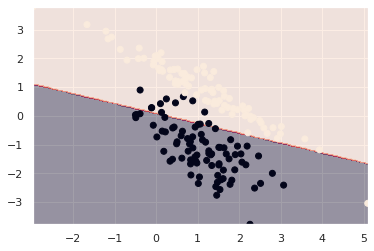

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

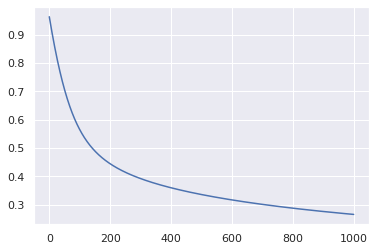

In [10]:
plt.plot(model.loss_history)

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: [0.5 point]
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset  [1.5 point]
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [11]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [12]:
import kaggle
kaggle.api.authenticate()

### For authentication an account at https://www.kaggle.com/ is required.

In [13]:
!kaggle datasets list -s 'russian-literature'

ref                                                               title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
d0rj3228/russian-literature                                       Russian literature                                   21MB  2021-11-05 14:17:08            688         26  0.9375           
zusmani/the-holy-quran                                            The Holy Quran                                       10MB  2017-11-20 09:46:11           3704        303  0.7647059        
oldaandozerskaya/fiction-corpus-for-agebased-text-classification  RusAge: Corpus for Age-Based Text Classification    509MB  2020-09-28 09:30:12            280         25  0.9411765        
jonnyjackk/college-entrance-exam-scores-in-vietnam

In [14]:
!kaggle datasets download -d 'd0rj3228/russian-literature'

russian-literature.zip: Skipping, found more recently modified local copy (use --force to force download)


### There are problems unzipping via "!unzip russian-literature", so I had to unzip with computer manager.

In [15]:
main_folder = 'russian-literature/prose/'
authors = ['Blok', 'Chekhov', 'Gorky', 'Lermontov', 'Pushkin', 'Turgenev']

In [16]:
def split_into_sentences(path):
    split_text = []
    with open(path, encoding="utf-8") as file:
        split_text = file.read()
    split_text = split_text.replace('!', '.').replace('?', '.').replace('…', '.').replace('\n', ' ')\
    .replace('--', '').replace('–', '').replace('«', '').replace('»', '').replace('—', '')\
    .split('.')
    split_text = [split_text[i] for i in range(0, len(split_text)) if len(split_text[i]) >= 15]
    return split_text

In [17]:
import glob

sentences_lst = []
for author in authors:
    author_sentences = []
    for path in glob.glob(main_folder + author + '/*.txt'):
        author_sentences += split_into_sentences(path)
    sentences_lst.append(author_sentences)
for i in range(0, 6):
    print(authors[i], len(sentences_lst[i]))

Blok 433
Chekhov 25994
Gorky 53882
Lermontov 3588
Pushkin 10762
Turgenev 28764


In [18]:
import random
random.seed(42)

#Blok is 3k
sentences_lst[3] = random.sample(sentences_lst[3], int(7 * len(sentences_lst[0]) / 3)) #7k
sentences_lst[4] = random.sample(sentences_lst[4], int(15 * len(sentences_lst[0]) / 3)) #15k
sentences_lst[1] = random.sample(sentences_lst[1], int(20 * len(sentences_lst[0]) / 3)) #20k
sentences_lst[5] = random.sample(sentences_lst[5], int(30 * len(sentences_lst[0]) / 3)) #30k
sentences_lst[2] = random.sample(sentences_lst[2], int(40 * len(sentences_lst[0]) / 3)) #40k

In [19]:
random.seed(42)

authors_lst = []
for i in range(0, 6):
    authors_lst += [authors[i]] * len(sentences_lst[i])
sentences_lst = [item for sublist in sentences_lst for item in sublist]

zipped = list(zip(authors_lst, sentences_lst))
random.shuffle(zipped)
authors_lst, sentences_lst = zip(*zipped)

sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentences_lst
sentences_df['author'] = authors_lst
sentences_df.info()
sentences_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16597 entries, 0 to 16596
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  16597 non-null  object
 1   author    16597 non-null  object
dtypes: object(2)
memory usage: 259.5+ KB


,sentence,author
0,"Любовь на секунду остановилась в дверях, кра...",Gorky
1,Оно по-прежнему не колебалось и стояло твердо...,Turgenev
2,Старый башкирец молчал и глядел на коменданта...,Pushkin
3,Миленькие вдовушки в девках не сидят; то есть...,Pushkin
4,Это совсем таки интересно любопытно было бы...,Chekhov


In [20]:
import string # for work with strings
import nltk   # Natural Language Toolkit

# get russian stop words
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# define word tokenizer
word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nickyoleary/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
dates = [str(x) for x in np.arange(0, 5000)]
def process_data(data):
    words = []
    for sentence in data['sentence']:
        # collect nlabels of news
        sentence_lower = sentence.lower() # convert words in a text to lower case
        tokens = word_tokenizer.tokenize(sentence_lower) # splits the text into tokens (words)
        # remove punct and stop words from tokens
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]
        words.append(tokens) # collect the text tokens
    return words

In [22]:
words = process_data(sentences_df)
words[:3]

[['любовь',
  'секунду',
  'остановилась',
  'дверях',
  'красиво',
  'прищурив',
  'глаза',
  'гордо',
  'сжав',
  'губы'],
 ['оно', 'прежнему', 'колебалось', 'стояло', 'твердо', 'брошенный', 'якорь'],
 ['старый',
  'башкирец',
  'молчал',
  'глядел',
  'коменданта',
  'видом',
  'совершенного',
  'бессмыслия']]

In [23]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

morph_words = []
for words_lst in words:
    morph_words.append([morph.parse(word)[0].normal_form for word in words_lst])
morph_words[:3]

[['любовь',
  'секунда',
  'остановиться',
  'дверь',
  'красиво',
  'прищурить',
  'глаз',
  'гордо',
  'сжать',
  'губа'],
 ['оно', 'прежний', 'колебаться', 'стоять', 'твёрдо', 'бросить', 'якорь'],
 ['старый',
  'башкирец',
  'молчать',
  'глядеть',
  'комендант',
  'вид',
  'совершенный',
  'бессмыслие']]

In [24]:
morph_sentences = []
for morph_sentence_words in morph_words:
    morph_sentence = str()
    for morph_word in morph_sentence_words:
        morph_sentence += morph_word + ' '
    morph_sentences.append(morph_sentence)
sentences_df['processed_sentence'] = morph_sentences
sentences_df.info()
sentences_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16597 entries, 0 to 16596
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sentence            16597 non-null  object
 1   author              16597 non-null  object
 2   processed_sentence  16597 non-null  object
dtypes: object(3)
memory usage: 389.1+ KB


,sentence,author,processed_sentence
0,"Любовь на секунду остановилась в дверях, кра...",Gorky,любовь секунда остановиться дверь красиво прищ...
1,Оно по-прежнему не колебалось и стояло твердо...,Turgenev,оно прежний колебаться стоять твёрдо бросить я...
2,Старый башкирец молчал и глядел на коменданта...,Pushkin,старый башкирец молчать глядеть комендант вид ...
3,Миленькие вдовушки в девках не сидят; то есть...,Pushkin,миленький вдовушка девка сидеть хотеть сказать...
4,Это совсем таки интересно любопытно было бы...,Chekhov,это таки интересно любопытно послушать честной...


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
bag_vectorizer = CountVectorizer(max_features = 50)
bag_vectorizer.fit(sentences_df['processed_sentence'].values.tolist())
bag_vectorizer.get_feature_names()[:10]

/home/nickyoleary/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['бог',
 'быть',
 'ваш',
 'весь',
 'взять',
 'видеть',
 'время',
 'всё',
 'глаз',
 'говорить']

In [26]:
bag_sentences = bag_vectorizer.transform(sentences_df['processed_sentence'])
bag_sentences.todense()[:5]

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
         0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 1]])

### The popularity of a word is calculated as its overall frequency in all of the sentences. Columns are 50 most popular words, rows are sentences. An element [i, j] of the table represents the frequency of the word j in sentence i.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
td_idf_vectorizer = TfidfVectorizer(max_features = 100)
td_idf_vectorizer.fit(sentences_df['processed_sentence'])
td_idf_vectorizer.get_feature_names()[:10]

['бог',
 'брат',
 'быть',
 'ваш',
 'весь',
 'взять',
 'видеть',
 'время',
 'всякий',
 'всё']

In [28]:
td_idf_sentences = td_idf_vectorizer.transform(sentences_df['processed_sentence'])
td_idf_sentences.todense()[:5]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.62901096, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.77739643, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

### The popularity of a word takes into consideration not only the overall frequency, but also distribution of this frequency around sentences, i.e. the number of sentences with this word and the frequency of the word in those sentences. Columns are 100 most popular words, rows - sentences. An element [i, j] of the table represents the frequency of the word j in sentence i, multiplied by log of the overall number of sentences divided by the number of sentences containing the given word.

### Thus, some differences in the popularities of words between these two models are acceptable.

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. [1 point]
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. [1 point]
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

**HINT:** In the task 8.2 you should analyze models for binary classification task. How do you think the AUC_ROC should be high? Is the 0.6 enough for us?

In [29]:
partial_df = sentences_df[(sentences_df['author'] =='Turgenev') | (sentences_df['author'] == 'Gorky')]
partial_df['author_index'] = [1 if x == 'Gorky' else -1 for x in partial_df['author']]
partial_df = partial_df.reset_index(drop=True)
print('Balance coefficient:', partial_df[partial_df['author'] == 'Gorky'].shape[0] / \
     partial_df[partial_df['author'] == 'Turgenev'].shape[0])
partial_df.head()

Balance coefficient: 1.333256351039261


/tmp/ipykernel_41867/838257568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  partial_df['author_index'] = [1 if x == 'Gorky' else -1 for x in partial_df['author']]


,sentence,author,processed_sentence,author_index
0,"Любовь на секунду остановилась в дверях, кра...",Gorky,любовь секунда остановиться дверь красиво прищ...,1
1,Оно по-прежнему не колебалось и стояло твердо...,Turgenev,оно прежний колебаться стоять твёрдо бросить я...,-1
2,"- Машей,- отвечала она тихим голосом, украдк...",Turgenev,маша отвечать тихий голос украдкой взглянуть,-1
3,Худые старички в скромных сюртуках читали рус...,Turgenev,худой старичок скромный сюртук читать русский ...,-1
4,Да ведь как говорил,Turgenev,говорить,-1


In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV

train_X, test_X, train_y, test_y = train_test_split(partial_df['processed_sentence'], partial_df['author_index'],\
                                                    stratify=partial_df['author_index'], test_size=0.25, \
                                                    random_state=42)

In [31]:
vectorizer = TfidfVectorizer(max_features=100) 
vectorizer.fit(train_X)
train_X = vectorizer.transform(train_X)
test_X = vectorizer.transform(test_X)

train_X = np.array(train_X.todense())
test_X = np.array(test_X.todense())
train_y = np.array(train_y)
test_y = np.array(test_y)

In [32]:
from sklearn.metrics import *

def show_results(test_y, pred, proba):
    print("Precision: {0:6.2f}".format(precision_score(test_y, pred, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y, pred, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y, pred, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print("ROC-AUC  =  {0:6.2f}".format(roc_auc_score(test_y, proba)))
    print('\n')
    labels = ['negative','positive']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

Best parameters:  {'beta': 0.0, 'gamma': 0.5, 'lr': 0.01, 'max_iter': 1000}
Precision:   0.29
Recall:   0.50
F1-measure:   0.36
Accuracy:   0.57
ROC-AUC  =    0.52




/home/nickyoleary/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


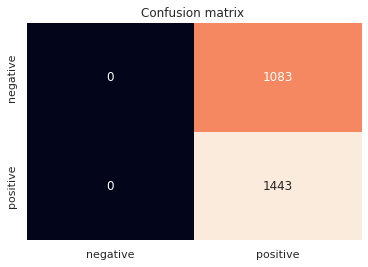

In [33]:
from sklearn.model_selection import GridSearchCV

parameters = {'beta': np.linspace(0, 1, 3), 'gamma' : np.linspace(0, 1, 3),\
              'lr': np.logspace(-3, -1, 3),'max_iter': np.linspace(1000, 2000, 3, dtype=int)}
clf = GridSearchCV(Logit(), parameters, scoring='f1', n_jobs=-1)
clf.fit(train_X, train_y)
print('Best parameters: ', clf.best_params_)
pred_y = clf.predict(test_X)
proba_y  = clf.predict_proba(test_X)
show_results(test_y, pred_y, proba_y)

Fitting 2 folds for each of 56 candidates, totalling 112 fits
{'C': 0.1, 'class_weight': None, 'kernel': 'sigmoid'}
Precision:   0.64
Recall:   0.56
F1-measure:   0.51
Accuracy:   0.61
ROC-AUC  =    0.64




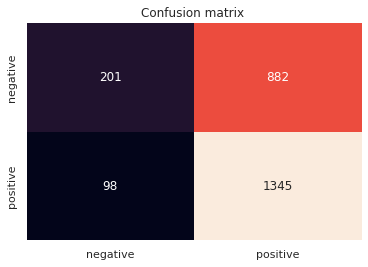

In [34]:
from sklearn.svm import SVC

parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(-3, 3, 7), \
              'class_weight' : ['balanced', None]}
svr = SVC(probability=True, verbose = False)
clf = GridSearchCV(svr, parameters, scoring='f1', verbose=2, cv=2, n_jobs=-1)
clf.fit(train_X, train_y)
print(clf.best_params_)
pred_y = clf.predict(test_X)
proba_y  = clf.predict_proba(test_X)
show_results(test_y, pred_y, proba_y[:,1])

### As we can see, both the Logit and the SVC classifiers demonstrate quite a bad performance with f1-score.  This may be due to completely different issues, for instance: max_features in vectorizer, balance of the data, threshold etc. Moreover, any model seems to be unstable due to the dataset content, which can always be unrepresentative.

Best parameters:  {'beta': 0.5, 'gamma': 0.0, 'lr': 0.1, 'max_iter': 2000}
Precision:   0.29
Recall:   0.50
F1-measure:   0.36
Accuracy:   0.57
ROC-AUC  =    0.66




/home/nickyoleary/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


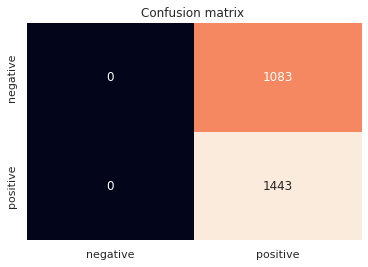

In [35]:
parameters = {'beta': np.linspace(0, 1, 3), 'gamma' : np.linspace(0, 1, 3),\
              'lr': np.logspace(-3, -1, 3), 'max_iter': np.linspace(1000, 2000, 3, dtype=int)}
clf = GridSearchCV(Logit(), parameters, scoring='roc_auc', n_jobs=-1)
clf.fit(train_X, train_y)
pred_y = clf.predict(test_X)
proba_y  = clf.predict_proba(test_X)
print('Best parameters: ', clf.best_params_)
show_results(test_y, pred_y, proba_y)

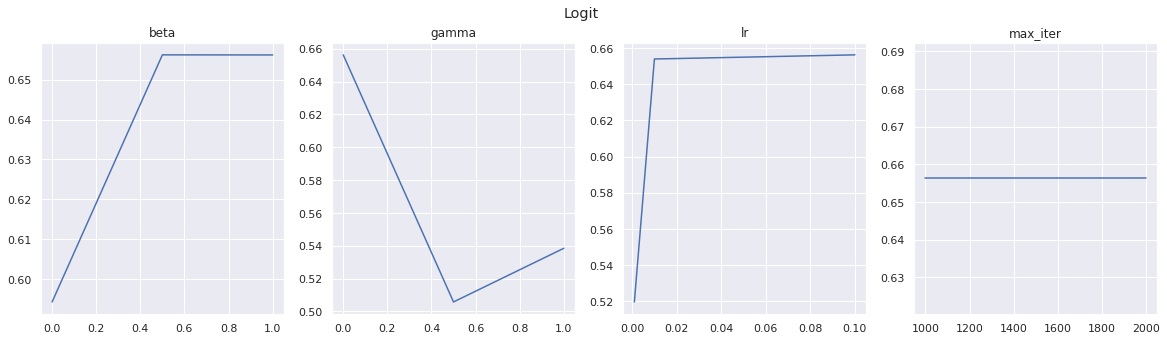

In [36]:
beta_lst = []
for beta in np.linspace(0, 1, 3):
    model = Logit(beta=beta, gamma=clf.best_params_['gamma'], lr=clf.best_params_['lr'],\
                 max_iter=clf.best_params_['max_iter'])
    model.fit(train_X, train_y)
    proba_y  = model.predict_proba(test_X)
    beta_lst.append(roc_auc_score(test_y, proba_y))

gamma_lst = []
for gamma in np.linspace(0, 1, 3):
    model = Logit(beta=clf.best_params_['beta'], gamma=gamma, lr=clf.best_params_['lr'],\
                 max_iter=clf.best_params_['max_iter'])
    model.fit(train_X, train_y)
    proba_y  = model.predict_proba(test_X)
    gamma_lst.append(roc_auc_score(test_y, proba_y))

lr_lst = []
for lr in np.logspace(-3, -1, 3):
    model = Logit(beta=clf.best_params_['beta'], gamma=clf.best_params_['gamma'], lr=lr,\
                 max_iter=clf.best_params_['max_iter'])
    model.fit(train_X, train_y)
    proba_y  = model.predict_proba(test_X)
    lr_lst.append(roc_auc_score(test_y, proba_y))

max_iter_lst = []
for max_iter in np.linspace(1000, 2000, 3, dtype=int):
    model = Logit(beta=clf.best_params_['beta'], gamma=clf.best_params_['gamma'], lr=clf.best_params_['lr'],\
                 max_iter=max_iter)
    model.fit(train_X, train_y)
    proba_y  = model.predict_proba(test_X)
    max_iter_lst.append(roc_auc_score(test_y, proba_y))

fig, axs = plt.subplots(1, 4, figsize=(20,5))
fig.suptitle('Logit')
axs[0].set_title('beta')
axs[0].plot(np.linspace(0, 1, 3), beta_lst)
axs[1].set_title('gamma')
axs[1].plot(np.linspace(0, 1, 3), gamma_lst)
axs[2].set_title('lr')
axs[2].plot(np.logspace(-3, -1, 3), lr_lst)
axs[3].set_title('max_iter')
axs[3].plot(np.linspace(1000, 2000, 3), max_iter_lst)

### Somewhy, the Logit model still refuses to predict one of 2 classes. An obvious idea is to try changing the threshold value, but it seems to be baseless: a huge variety of factors could have influenced the result.

Fitting 2 folds for each of 56 candidates, totalling 112 fits
{'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Precision:   0.63
Recall:   0.61
F1-measure:   0.58
Accuracy:   0.59
ROC-AUC  =    0.65




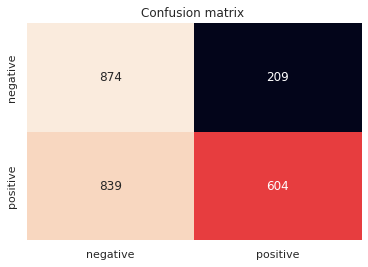

In [37]:
parameters = {'kernel':('linear', 'rbf', 'poly', 'sigmoid'), 'C': np.logspace(-3, 3, 7), \
              'class_weight' : ['balanced', None]}
svr = SVC(probability=True, verbose = False)
clf = GridSearchCV(svr, parameters, scoring = 'roc_auc', verbose=2, cv=2, n_jobs=-1)
clf.fit(train_X, train_y)
print(clf.best_params_)
pred_y = clf.predict(test_X)
proba_y  = clf.predict_proba(test_X)
show_results(test_y, pred_y, proba_y[:,1])

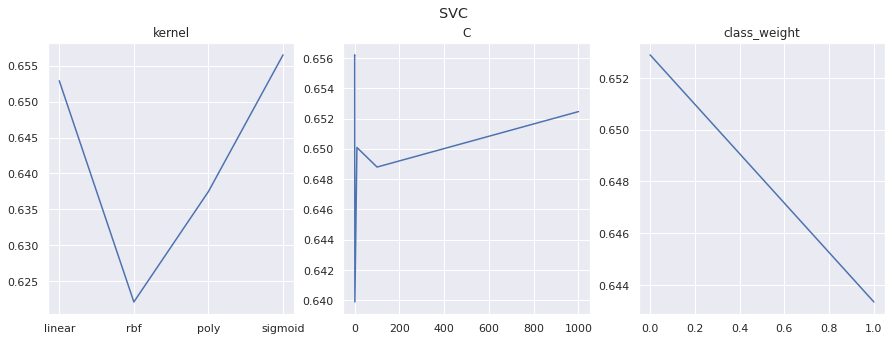

In [43]:
kernel_lst = []
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    model = SVC(kernel=kernel, C=clf.best_params_['C'], class_weight=clf.best_params_['class_weight'])
    model.fit(train_X, train_y)
    proba_y  = model.decision_function(test_X)
    kernel_lst.append(roc_auc_score(test_y, proba_y))

C_lst = []
for C in np.logspace(-3, 3, 7):
    model = SVC(kernel=clf.best_params_['kernel'], C=C, class_weight=clf.best_params_['class_weight'])
    model.fit(train_X, train_y)
    proba_y  = model.decision_function(test_X)
    C_lst.append(roc_auc_score(test_y, proba_y))

class_weight_lst = []
for class_weight in ['balanced', None]:
    model = SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], class_weight=class_weight)
    model.fit(train_X, train_y)
    proba_y  = model.decision_function(test_X)
    class_weight_lst.append(roc_auc_score(test_y, proba_y))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('SVC')
axs[0].set_title('kernel')
axs[0].plot(['linear', 'rbf', 'poly', 'sigmoid'], kernel_lst)
axs[1].set_title('C')
axs[1].plot(np.logspace(-3, 3, 7), C_lst)
axs[2].set_title('class_weight')
axs[2].plot(class_weight_lst)

### SVC model demonstrated an essential change to predicting another class more, but at the same time none of the metrics appeared to increase at least bit (most of them even slightly fell).

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

/home/nickyoleary/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


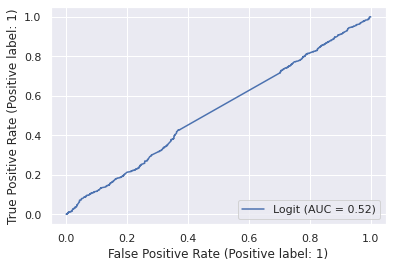

In [44]:
from sklearn import metrics

#Let us take best parameters from the previous task
model = Logit(beta=0.0, gamma=0.5, lr=0.01, max_iter=1000)
model.fit(train_X, train_y)
metrics.plot_roc_curve(model, test_X, test_y)

/home/nickyoleary/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


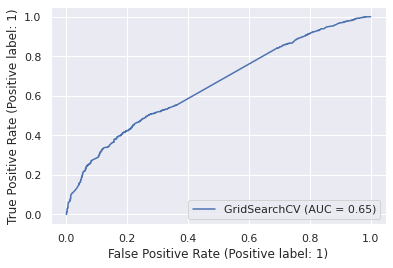

In [46]:
model = SVC(kernel='sigmoid', C=0.01, class_weight=None)
model.fit(train_X, train_y)
metrics.plot_roc_curve(clf, test_X, test_y)

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score). **HINT:** Do not forget about set jobs=-1 in the GridSearchCV init to speed up calculations.
* make conclusions about the model

In [47]:
sentences_df['author_index'] = [0 if x == 'Blok' else 1 if x == 'Lermontov' else \
                                2 if x == 'Pushkin' else 3 if x == 'Chekhov' else \
                                4 if x == 'Turgenev' else 5 for x in sentences_df['author']]

In [56]:
sentences_df.head(20)

,sentence,author,processed_sentence,author_index
0,"Любовь на секунду остановилась в дверях, кра...",Gorky,любовь секунда остановиться дверь красиво прищ...,5
1,Оно по-прежнему не колебалось и стояло твердо...,Turgenev,оно прежний колебаться стоять твёрдо бросить я...,4
2,Старый башкирец молчал и глядел на коменданта...,Pushkin,старый башкирец молчать глядеть комендант вид ...,2
3,Миленькие вдовушки в девках не сидят; то есть...,Pushkin,миленький вдовушка девка сидеть хотеть сказать...,2
4,Это совсем таки интересно любопытно было бы...,Chekhov,это таки интересно любопытно послушать честной...,3
5,"- Машей,- отвечала она тихим голосом, украдк...",Turgenev,маша отвечать тихий голос украдкой взглянуть,4
6,Худые старички в скромных сюртуках читали рус...,Turgenev,худой старичок скромный сюртук читать русский ...,4
7,(Закрывает лицо руками,Chekhov,закрывать лицо рука,3
8,одно из главных действующих лиц оставляет пол...,Chekhov,один главный действовать лицо оставлять поле б...,3
9,Она замучила меня своею ревностью,Lermontov,замучить свой ревность,1


In [79]:
train_X, test_X, train_y, test_y = train_test_split(sentences_df['processed_sentence'], sentences_df['author_index'],\
                                                    stratify=sentences_df['author_index'], test_size=0.25, \
                                                    random_state=42)

In [80]:
vectorizer = TfidfVectorizer(max_features=100) 
vectorizer.fit(train_X)
train_X = vectorizer.transform(train_X)
test_X = vectorizer.transform(test_X)

train_X = np.array(train_X.todense())
test_X = np.array(test_X.todense())
train_y = np.array(train_y)
test_y = np.array(test_y)

In [81]:
train_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [86]:
def show_results(test_y, pred, test_y_bin, pred_bin):
    print("Precision: {0:6.2f}".format(precision_score(test_y_bin, pred_bin, average='macro')))
    print("Recall: {0:6.2f}".format(recall_score(test_y_bin, pred_bin, average='macro')))
    print("F1-measure: {0:6.2f}".format(f1_score(test_y_bin, pred_bin, average='macro')))
    print("Accuracy: {0:6.2f}".format(accuracy_score(test_y, pred)))
    print('\n')
    labels = ['Blok','Lermontov', 'Pushkin', 'Chekhov', 'Turgenev', 'Gorky']

    #classification_report
    sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title("Confusion matrix ")
    plt.show()

In [88]:
def unbinarize(y_bin):
    result = []
    for i in range(y_bin.shape[0]):
        ind = (y_bin[i]).tolist().index(1)
        result.append(ind)
    return result

OneVsRest Strategy
Best parameters:  {'estimator__beta': 0.0, 'estimator__gamma': 0.0}
Train set
ROC AUC score  =   0.50
Precision:   0.17
Recall:   1.00
F1-measure:   0.27
Accuracy:   0.03




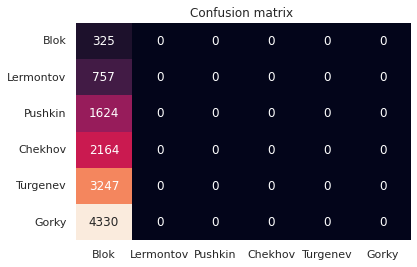

Test set
ROC AUC score  =   0.50
Precision:   0.17
Recall:   1.00
F1-measure:   0.27
Accuracy:   0.03




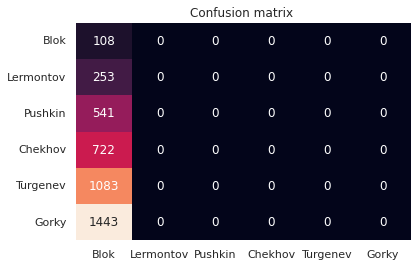

In [89]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

parameters = {'estimator__beta': np.linspace(0, 1, 2), 'estimator__gamma' : np.linspace(0, 1, 2)}

my_scorer = make_scorer(roc_auc_score, greater_is_better=True, multi_class = 'ovr')

train_y_bin = label_binarize(train_y, classes=[0, 1, 2, 3, 4, 5])
test_y_bin = label_binarize(test_y, classes=[0, 1, 2, 3, 4, 5])

svr = OneVsRestClassifier(Logit())
clf = GridSearchCV(svr, parameters, scoring=my_scorer, cv=2, n_jobs=-1)
clf.fit(train_X, train_y_bin)
print('OneVsRest Strategy')
print('Best parameters: ', clf.best_params_)
print('Train set')
print("ROC AUC score  = {0:6.2f}".format(clf.score(train_X, train_y_bin)))
pred_y_bin = clf.predict(train_X)
show_results(train_y, unbinarize(pred_y_bin), train_y_bin, pred_y_bin)
print('Test set')
print("ROC AUC score  = {0:6.2f}".format(clf.score(test_X, test_y_bin)))
pred_y_bin = clf.predict(test_X)
show_results(test_y, unbinarize(pred_y_bin), test_y_bin, pred_y_bin)